## Описание проекта

Компания «Такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.




# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

На данном этепе я добавляю библиотеки, которые в дальнейшем буду использовать

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(data.info())
#data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Здесь я делаю вычитку из файла и вывожу таблицу

In [3]:
data.isna().sum()

num_orders    0
dtype: int64

Здесь я проверяю, есть ли пропущенные значения

In [4]:
print(data.index.is_monotonic)
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


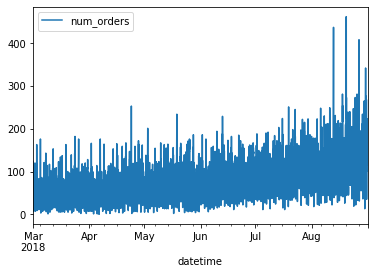

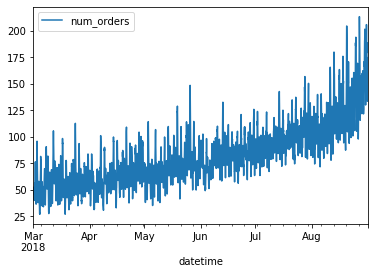

In [5]:
data = data.resample('1H').sum()
data.plot()
data.rolling(10).mean().plot()


На данном этапе я делаю ресемплирование по часу, а также строю графики, на которых можно видеть повышение активности заказа такси

# 2. Анализ

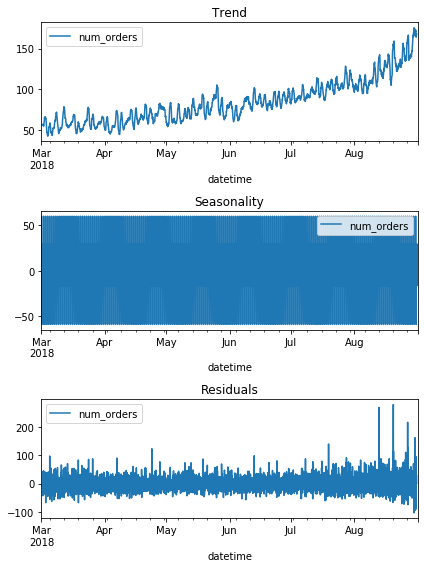

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд говорит о том, что большинство заказов производится к августу

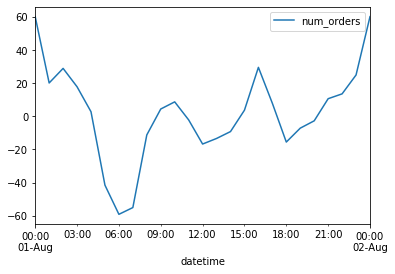

In [7]:
decomposed.seasonal['2018-08-01 00:00:00' : '2018-08-02 00:00:00'].plot()

На данном графике видно самое большое количество заказов в 00:00, а самое малое число заказов в 6:00, и так повторяется ежедневно

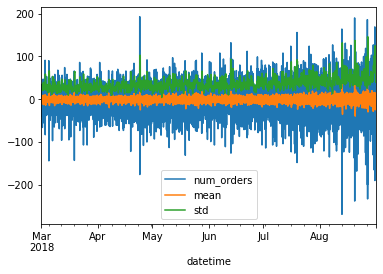

In [8]:
data = data - data.shift()
data['mean'] = data['num_orders'].rolling(8).mean()
data['std'] = data['num_orders'].rolling(8).std()
data.plot()

# 3. Обучение

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 4, 6)
#data.head()

Здесь я пишу функцию, которая создает признаки для обучения модели

In [10]:
df, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(df, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-07-27 23:00:00
2018-07-28 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Здесь я разбиваю данные на тренировочную, валидационную и тестовую выборки

In [11]:
pred_median = np.ones(valid.shape) * train['num_orders'].median()
rmse = mean_squared_error(valid, pred_median) ** 0.5
rmse

583.2724478389329

In [12]:
pred_previous = valid.shift()
pred_previous.iloc[0]=train.iloc[-1]
rmse = mean_squared_error(valid, pred_previous) ** 0.5
rmse

48.59902511948402

Здесь я записал константную модель и оцениваю качество ее предсказания

In [13]:
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [14]:
model =  LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)

pred_valid = model.predict(features_valid)

print('rmse на тренеровочной:', mean_squared_error(target_train, pred_train) ** 0.5)

print('rmse на валидационной:', mean_squared_error(target_valid, pred_valid) ** 0.5)


rmse на тренеровочной: 23.262653167254037
rmse на валидационной: 31.866851117312954


Здесь я осуществляю обучение модели и оцениваю предсказания на тренеровочной и валидационной выборках

# 4. Тестирование

In [15]:
pred_test = model.predict(features_test)

print('rmse на тестовой:', mean_squared_error(target_test, pred_test) ** 0.5)

rmse на тестовой: 39.84515790054173


Здесь предсказываю на тестовой модели и оцениваю качество предсказания на тестовой выборке, которое получилось меньше 48